# Stock Market Prediction and Forecasting Using Stacked LSTM
Using Keras and Tensorflow

##### Dataset
Yahoo Finance - Stock of Reliance Industries Limited
NSE: RELIANCE: https://finance.yahoo.com/quote/RELIANCE.NS/history?period1=1433635200&period2=1591488000&interval=1d&filter=history&frequency=1d


In [1]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [2]:
#Import the data and remove rows containing NAN values
df = pd.read_csv('Reliance_Stock.csv')
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-06-08,453.399994,455.000000,441.549988,442.725006,425.550629,4958862.0
1,2015-06-09,441.774994,445.325012,438.674988,441.850006,424.709564,4184606.0
2,2015-06-10,443.000000,454.950012,442.500000,452.899994,435.330933,6176034.0
3,2015-06-11,453.000000,454.750000,436.825012,438.575012,421.561676,6709574.0
4,2015-06-12,439.500000,446.350006,439.125000,444.924988,427.665283,9849112.0


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1224,2020-06-01,1480.0,1538.349976,1475.949951,1520.349976,1520.349976,18434012.0
1225,2020-06-02,1526.0,1540.000000,1520.800049,1535.699951,1535.699951,10224049.0
1226,2020-06-03,1545.0,1560.000000,1533.349976,1541.650024,1541.650024,11713461.0
1227,2020-06-04,1544.0,1589.500000,1541.000000,1579.800049,1579.800049,15784379.0
1228,2020-06-05,1595.0,1618.000000,1573.699951,1581.699951,1581.699951,15246965.0


In [4]:
df_close = df['Close']

In [5]:
df_close.shape

(1228,)

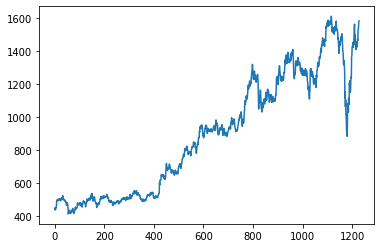

In [6]:
plt.plot(df_close)

Since LSTM are sensitive to the scale of the data, so we apply MinMax Scaler to transform our values between 0 and 1

In [7]:
scaler = MinMaxScaler(feature_range = (0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [8]:
df_close.shape

(1228, 1)

In [9]:
df_close

array([[0.02338571],
       [0.0226536 ],
       [0.0318991 ],
       ...,
       [0.94285362],
       [0.97477365],
       [0.97636329]])

In [10]:
#Split the data into train and test split
training_size = int(len(df_close) * 0.75)
test_size = len(df_close) - training_size
train_data, test_data = df_close[0:training_size,:], df_close[training_size:len(df_close),:1]

In [11]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [13]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [14]:
#Create the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
13/13 [==============================] - 12s 402ms/step - loss: 0.0658 - val_loss: 0.0552
Epoch 2/100
13/13 [==============================] - 4s 317ms/step - loss: 0.0078 - val_loss: 0.0121
Epoch 3/100
13/13 [==============================] - 4s 319ms/step - loss: 0.0028 - val_loss: 0.0097
Epoch 4/100
13/13 [==============================] - 4s 320ms/step - loss: 0.0015 - val_loss: 0.0090
Epoch 5/100
13/13 [==============================] - 4s 321ms/step - loss: 0.0010 - val_loss: 0.0099
Epoch 6/100
13/13 [==============================] - 4s 317ms/step - loss: 8.8859e-04 - val_loss: 0.0085
Epoch 7/100
13/13 [==============================] - 4s 316ms/step - loss: 9.4581e-04 - val_loss: 0.0082
Epoch 8/100
13/13 [==============================] - 4s 317ms/step - loss: 9.4617e-04 - val_loss: 0.0085
Epoch 9/100
13/13 [==============================] - 4s 317ms/step - loss: 9.9676e-04 - val_loss: 0.0085
Epoch 10/100
13/13 [==============================] - 4s 320ms/step - loss

In [17]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [18]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [19]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

807.375552547247

In [20]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

1324.8207222524886

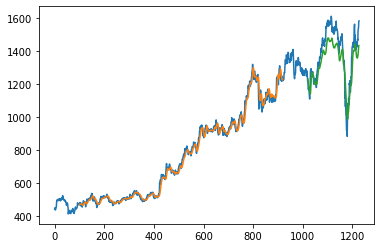

In [22]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_close) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Predict the next 30 days Stock Price

In [23]:
len(test_data), x_test.shape

(307, (206, 100, 1))

In [24]:
x_input = test_data[207:].reshape(1,-1)
x_input.shape

(1, 100)

In [25]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [26]:
lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.8846044]
101
1 day input [0.94816663 0.9478738  0.94456879 0.93260407 0.92796036 0.939716
 0.97577765 0.93507229 0.93636921 0.93590899 0.93047045 0.92603602
 0.91348555 0.88436843 0.89114567 0.8609409  0.83408293 0.81220327
 0.84642422 0.86491522 0.87269654 0.85249028 0.8541218  0.86847118
 0.88315526 0.88637653 0.89763007 0.88980697 0.88072882 0.91118463
 0.8962495  0.8619449  0.83805724 0.8176418  0.81283079 0.76463703
 0.75417831 0.7765181  0.77388248 0.74999482 0.71640139 0.5851654
 0.6181313  0.5423683  0.57776065 0.50279251 0.49634993 0.46330038
 0.42079615 0.50467508 0.39264125 0.44229929 0.55847473 0.54504569
 0.54454369 0.51513375 0.5848307  0.55696863 0.55445854 0.6620997
 0.65042781 0.67368794 0.64791772 0.61503546 0.63026342 0.67707661
 0.69364326 0.6882465  0.79387957 0.7999875  0.83855924 0.84922714
 0.84788844 0.84688434 0.86803608 0.84250843 0.86360165 0.86368529
 0.90198096 0.9474387  0.95987202 0.87902192 0.90503482 0.85441462
 0.87403524 0.85843081 0.83178201 0.85

In [27]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [28]:
df3 = df_close.tolist()
df3.extend(lst_output)

In [29]:
len(df_close)

1228

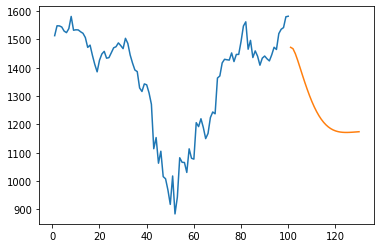

In [30]:
plt.plot(day_new, scaler.inverse_transform(df_close[1128:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))